# Problem Set 3, due October 2 at 11:59pm.

### Before You Start

Make sure the following libraries load correctly (hit Ctrl-Enter). Note that while you are loading several powerful libraries, including machine learning libraries, the goal of this problem set is to implement several algorithms from scratch. In particular, you should *not* be using any built-in libraries for nearest neighbors, distance metrics, or cross-validation -- your mission is to write those algorithms in Python! Part 1 will be relatively easy; Part 2 will take more time.

In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn

---

## Introduction to the assignment

For this assignment, you will be using the [Boston Housing Prices Data Set](http://www.kellogg.northwestern.edu/faculty/weber/emp/_session_3/boston.htm).  Please read about the dataset carefully before continuing.  Use the following commands to load the dataset:


In [2]:
from sklearn.datasets import load_boston
bdata = load_boston()

---

## Part 1: Experimental Setup

The goal of the next few sections is to design an experiment to predict the median home value for an instance in the data.
Before beginning the "real" work, refamiliarize yourself with the dataset.

### 1.1 Begin by writing a function to compute the Root Mean Squared Error for a list of numbers

You can find the sqrt function in the Numpy package. Furthermore the details of RMSE can be found on [Wikipedia](http://en.wikipedia.org/wiki/Root-mean-square_deviation). Do not use a built-in function (other than sqrt) to compute RMSE.



In [3]:
"""
Function
--------
compute_rmse

Given two arrays, one of actual values and one of predicted values,
compute the Roote Mean Squared Error

Parameters
----------
predictions : array
    Array of numerical values corresponding to predictions for each of the N observations

yvalues : array
    Array of numerical values corresponding to the actual values for each of the N observations

Returns
-------
rmse : int
    Root Mean Squared Error of the prediction

Example
-------
>>> print(compute_rmse((2,2,3),(0,2,6)))
2.08
"""
def compute_rmse(predictions, yvalues):
    if not isinstance(predictions, list):
        predictions = np.asarray(predictions)
    if not isinstance(yvalues, list):
        yvalues = np.asarray(yvalues)
    pred_yvals_zipped = zip(predictions, yvalues)
    rmse = np.sqrt(sum([(p-y)**2 for p, y in pred_yvals_zipped])/len(yvalues))
    if type(rmse) is np.ndarray:
        rmse = rmse[0]
    return rmse

### 1.2 Divide your data into training and testing datasets

Randomly select 80% of the data and put this in a training dataset (call this "bdata_train"), and place the remaining 20% in a testing dataset (call this "bdata_test")


In [4]:
# leave the following line untouched, it will help ensure that your "random" split is the same "random" split used by the rest of the class
np.random.seed(seed=13579)

bdata_data = pd.DataFrame(bdata['data'])
features = list(bdata['feature_names'])
bdata_data.columns = features

train_idx = np.random.choice(range(len(bdata_data)), int(len(bdata_data) * .8), replace=False)
test_idx = list(set(range(len(bdata_data))) - set(list(train_idx)))

bdata_train = bdata_data.loc[train_idx, features]
bdata_test = bdata_data.loc[test_idx, features]


### 1.3 Use a very bad baseline for prediction, and compute RMSE

Create a model that predicts, for every observation x_i, that the median home value is the average (mean) of the median values for all instances in the training set.  Specifically, do the following:
1. Compute the RMSE of the training set.
2. Now compute the RMSE on the test data set (but use the model you trained on the training set!).
3. How does RMSE compare for training vs. testing datasets? Is this what you expected, and why?
4. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. Color the training instances in blue and the test instances in red. Make sure to label your axes appropriately, and add a legend to your figure to make clear which dots are which.
5. Add code to your function to measure the running time of your algorithm. How long does it take to compute the predicted values for the test data?

1. RMSE of the training set: 9.20728120783
Time taken: 0.00 seconds


2. RMSE of the test set: 9.11139618372
Time taken: 0.00 seconds


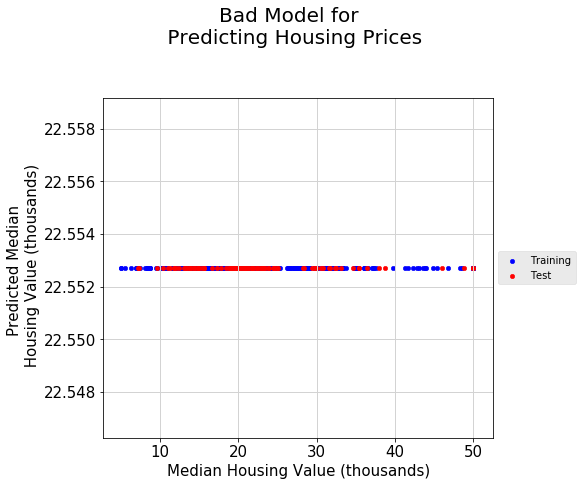

In [5]:
from matplotlib import pyplot as plt
import time

bdata_labels = pd.DataFrame(bdata['target']) # This is the median housing value (MEDV)
train_labels = bdata_labels.loc[train_idx]
test_labels = bdata_labels.loc[test_idx]

# Problem 1
bdata_train['all_mean'] = train_labels.mean()[0]
bdata_train['MEDV'] = train_labels

start_time = time.time()
print('1. RMSE of the training set:', compute_rmse(bdata_train['all_mean'], bdata_train['MEDV']))
end_time = time.time()
print("Time taken: {:.2f} seconds".format(end_time - start_time))

print('\n')

# Problem 2
bdata_test['all_mean'] = train_labels.mean()[0]
bdata_test['MEDV'] = test_labels
start_time = time.time()
print('2. RMSE of the test set:', compute_rmse(bdata_test['all_mean'], bdata_test['MEDV']))
end_time = time.time()
print("Time taken: {:.2f} seconds".format(end_time - start_time))


# Problem 4

fig = plt.figure(figsize=(7,7))
ax = fig.gca()
plt.style.use('ggplot')
ax.grid(color='lightgray', linestyle='-', linewidth=1)
fig.suptitle('Bad Model for \n Predicting Housing Prices', fontsize = 20)

ax.scatter( bdata_train['MEDV'], bdata_train['all_mean'], color='blue', s=20, label= 'Training')
ax.scatter(bdata_test['MEDV'],bdata_test['all_mean'], color='red', s=20, label = 'Test')

ax.set_facecolor('white')
plt.xlabel('Median Housing Value (thousands)', fontsize=15)
plt.ylabel('Predicted Median \n Housing Value (thousands)', fontsize=15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.subplots_adjust(bottom = None, top = 0.8)
plt.show()


bdata_train.drop(['all_mean'], axis=1 , inplace=True)
bdata_test.drop(['all_mean'], axis=1 , inplace=True)

### **Question 1**
RMSE of the training set: 9.20728120783

Time taken to run model: 0.00 seconds

### **Question 2**
RMSE of the test set: 9.11139618372

Time taken to run model: 0.00 seconds

### **Question 3**
This is roughly what I would expect. The "model" we used simply predicted all housing values were the same regardless of the features the model was given. Given we have a random sampling of training data and test data we expect that the RMSE of the test set should be roughly equal to the training set, which it is.

---

## Part 2: Nearest Neighbors


### 2.1 Nearest Neighbors: Distance function
Let's try and build a machine learning algorithm to beat the "Average Value" baseline that you computed above.  Soon you will implement the Nearest Neighbor algorithm, but first you need to create a distance metric to measure the distance (and similarity) between two instances.  Write a generic function to compute the L-Norm distance (called the [*p*-norm][1] distance on Wikipedia). Verify that your function works by computing the Euclidean distance between the points (3,4) and (6,8).
[1]: https://en.wikipedia.org/wiki/Norm_(mathematics)#p-norm

In [6]:
"""
Function
--------
distance

Given two instances and a value for L, return the L-Norm distance between them

Parameters
----------
x1, x2 : array
    Array of numerical values corresponding to predictions for each of the N observations

L: int
    Value of L to use in computing distances

Returns
-------
dist : int
    The L-norm distance between instances

Example
-------
>>> print(distance((3,4),(6,8),2))
5

"""
def distance(x1, x2, L):
    dist = sum(abs(np.array(x1)-np.array(x2))**L)**(1/L)
    return dist

### 2.2 Basic Nearest Neighbor algorithm

Your next task is to implement a basic nearest neighbor algorithm from scratch.  Your simple model will use two input features (CRIM and RM) and a single output (MEDV).  In other words, you are modelling the relationship between median home value and crime rates and house size.

Use your training data (bdata_train) to "fit" your model, although as you know, with Nearest Neighbors there is no real training, you just need to keep your training data in memory.  Write a function that predicts the median home value using the nearest neighbor algorithm we discussed in class.  Since this is a small dataset, you can simply compare your test instance to every instance in the training set, and return the MEDV value of the closest training instance.  Have your function take L as an input, where L is passed to the distance function.

Make sure to do the following
1. Fill in the function specification below
2. Use your algorithm to predict the median home value of every instance in the test set. Report the RMSE ("test RMSE")
3. Use your algorithm to predict the median home value of every instance in the training set and report the training RMSE.
4. Create a scatter plot that shows the true value of each instance on the x-axis and the predicted value of each instance on the y-axis. Color the training instances in blue and the test instances in red. 
5. Report an estimate of the total time taken by your code to predict the nearest neighbors for all the values in the test data set.
6. How does the performance (test RMSE and total runtime) of your nearest neighbors algorithm compare to the baseline in part 1.4?

Nearest neighbor time taken: 0.35 seconds
Q2: RMSE of test set: 7.70617272316


Nearest neighbor time taken: 1.12 seconds
Q3: RMSE of train set: 0.0


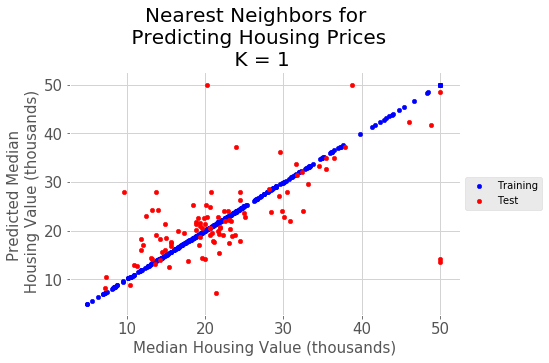

In [7]:
import time

"""
Function
--------
nneighbor

Given two features, an output of interest, a test set, a training set, a value for L, and correct test labels,
Return the RMSE of the labels predicted by Nearest Neighbors.

Parameters
----------
features : list of str
    a list containing the names of features to be used for training the model

output : list of single str
    A single element list containing the name of the column with the target output

test, train: dataframe
    Test contains all features of interest and no labels
    Train contains all features including the labels for the samples 

L: int
    Value of L to use in computing distances

test_labels: list or array
    A vector with the correct labels for the test set

print_time: boolean
    Defaults to True. Controls printing of time to run the function
    
Returns
-------
RSME: float
    The root mean squared error
    
test_MEDV: list
    Contains all the predicted values

Example
-------
>>> print(nneighbor('CRIM', 'RM', 'MEDV', bdata_test, bdata_train, 2, test_labels))
0.19802950859533486

"""
def nneighbor(features, output, test, train, test_labels, L, print_time=True):
    start_time = time.time()
    
    test_features = np.asarray(test[features])
    train_features = np.asarray(train[ features+output])
    
    # Use a min function, where the list is all the training features to compare and the matching label 
    # Use Distance() in the key to check each test features' distances to each train features' distances
    # Leave last value of feature out because this is the label
    # Append the last value (the label) to an empty list to be assigned as labels to the test samples
    test_MEDV = []
    for x1 in test_features:

        tmp = [[distance(x1, x[:len(features)], L), x[-1]] for x in train_features]
        tmp.sort()
        min_MED = tmp[0][-1]
        test_MEDV.append(min_MED)
    rmse = compute_rmse(test_MEDV, test_labels)
    end_time = time.time()
    if print_time:
        print("Nearest neighbor time taken: {:.2f} seconds".format(end_time - start_time))
    
    return rmse, test_MEDV

# Problem 1
bdata_train['all_mean'] = train_labels.mean()[0]
bdata_train['MEDV'] = train_labels

# Problem 2
rmse, test_pred = nneighbor(['CRIM', 'RM'], ['MEDV'], bdata_test, bdata_train, test_labels, 2)
print('Q2: RMSE of test set:', rmse)

print('\n')
# Problem 3
rmse, train_pred = nneighbor(['CRIM', 'RM'], ['MEDV'], bdata_train, bdata_train, train_labels, 2)
print('Q3: RMSE of train set:', rmse)


# Problem 4
fig = plt.figure(figsize=(7,5))
ax = fig.gca()
plt.style.use('ggplot')
ax.grid(color='lightgray', linestyle='-', linewidth=1)
fig.suptitle('Nearest Neighbors for \n Predicting Housing Prices \n K = 1', fontsize = 20)

ax.scatter(bdata_train['MEDV'], train_pred, color='blue', s=20, label = 'Training')
ax.scatter(bdata_test['MEDV'], test_pred, color='red', s=20, label = 'Test')

ax.set_facecolor('white')
plt.xlabel('Median Housing Value (thousands)', fontsize=15)
plt.ylabel('Predicted Median \n Housing Value (thousands)', fontsize=15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.subplots_adjust(bottom = None, top = 0.8)
plt.show()


### Question 2
Nearest neighbor time taken: 0.33 seconds

RSME of test set: 7.70617272316

### Question 3
RSME of train set: 0.0


### Question 5
The RMSE of the values predicted using the nearest neighbors model is lower than that of our bad model. This is to be expected because we actually used the features as a way to assign median housing values to the samples in our test set. By finding training samples that were the most similiar (closest in space) to the test sample, we assumed that those samples should have similar median housing values. In contrast though, this model takes longer to run. It took 0.33 seconds while the bad model took less than a thousandth of a second. We expect this to occur because we must compare all samples in our training set to each point in the test set.

### 2.3 Results and Normalization

If you were being astute, you would have noticed that we never normalized our features -- a big no-no with Nearest Neighbor algorithms.  Write a generic normalization function that takes as input an array of values for a given feature, and returns the normalized array (subtract the mean and divide by the standard deviation).

Re-run the Nearest Neighbor algorithm on the normalized dataset (still just using CRIM and RM as input), and compare the RMSE from this method with your previous RMSE evaluations. What do you observe?

*NOTE*: To normalize properly, best practice is to compute the mean and standard deviation on the training set, and use these values to normalize the testing dataset. However, for this problem set, it is okay if you separately normalize each dataset using the respective mean and standard deviation.

In [8]:
"""
Function
--------
normalize

Given a dataframe normalize all the specified columns using (Xi - mean(X))/ std(X)

Parameters
----------
data : data frame
    Unmodified values from the data set
features: list of str
    A list that contains the head names of all features to be normalized

Returns
-------
data: dataframe
    A new dataframe containing len(features) new columns with normalized data

Example
-------
>>> print(normalize(bdata_data, features).columns)
['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV', 'CRIM_norm', 'ZN_norm', 'INDUS_norm',
       'CHAS_norm', 'NOX_norm', 'RM_norm', 'AGE_norm', 'DIS_norm', 'RAD_norm',
       'TAX_norm', 'PTRATIO_norm', 'B_norm', 'LSTAT_norm']

"""
def normalize(data, features):
    if not isinstance(data, list):
        np.array(data)
    for f in features:
        data[f+'_norm'] = [(i - np.mean(data[f]))/np.std(data[f]) for i in data[f]]
    return data

# Reload the data and normalize all before splitting into train and test sets again
np.random.seed(seed=13579)

bdata_data = pd.DataFrame(bdata['data'])
features = list(bdata['feature_names'])
bdata_data.columns = features

bdata_data = normalize(bdata_data, ['CRIM', 'RM'])

train_idx = np.random.choice(range(len(bdata_data)), int(len(bdata_data) * .8), replace=False)
test_idx = list(set(range(len(bdata_data))) - set(list(train_idx)))

bdata_train = bdata_data.loc[train_idx, :]
bdata_test = bdata_data.loc[test_idx, :]

bdata_labels = pd.DataFrame(bdata['target']) # This is the median housing value (MEDV)
train_labels = bdata_labels.loc[train_idx]
test_labels = bdata_labels.loc[test_idx]

bdata_train['MEDV'] = train_labels


# Problem 2
rmse, test_pred = nneighbor(['CRIM_norm', 'RM_norm'], ['MEDV'], bdata_test, bdata_train, test_labels, 2)
print('RMSE of test set on normalized data:', rmse)

print('\n')
# Problem 3
rmse, train_pred = nneighbor(['CRIM_norm', 'RM_norm'], ['MEDV'], bdata_train, bdata_train, train_labels, 2)
print('RMSE of train set on normalized data:', rmse)


Nearest neighbor time taken: 0.28 seconds
RMSE of test set on normalized data: 7.41137837462


Nearest neighbor time taken: 1.11 seconds
RMSE of train set on normalized data: 0.0


The first observation is that normalizing allows the nearest neighbor algorithm to run faster. Secondly, we do see a lower RMSE value on the test set after normalizing. This is because when values are normalized, two different features with possibly very different scales are converted to a similar scale. Therefore when computing distances in the case of nearest neighbors, one dimension is not skewed more than another.

### 2.4 Optimization

A lot of the decisions we've made so far have been arbitrary.  Try to increase the performance of your nearest neighbor algorithm by adding features that you think might be relevant, and by using different values of L in the distance function.  Try a model that uses a different set of 2 features, then try at least one model that uses more than 4 features, then try using a different value of L.  If you're having fun, try a few different combinations of features and L!

What combination of features and distance function provide the lowest RMSE?  Do your decisions affect the running time of the algorithm?

*NOTE:* For this and all subsequent questions, you should use normalized features

In [9]:
bdata_test = normalize(bdata_test, ['PTRATIO', 'B', 'LSTAT', 'CHAS'])
bdata_train = normalize(bdata_train, ['PTRATIO', 'B', 'LSTAT', 'CHAS'])
bdata_train['MEDV'] = train_labels

L = 2
rmse, pred = nneighbor(['PTRATIO_norm', 'B_norm'], ['MEDV'], bdata_test, bdata_train, test_labels, L)
print('Nearest Neighbors using Pupil-teacher ratio and proportion of black people in town')
print('L =', L)
print('RMSE value:', rmse)

print('\n')

L = 4
rmse, pred = nneighbor(['PTRATIO_norm', 'B_norm'], ['MEDV'], bdata_test, bdata_train, test_labels, L)
print('Nearest Neighbors using Pupil-teacher ratio and proportion of black people in town')
print('L =', L)
print('RMSE value:', rmse)

print('\n')
L = 3
rmse, pred = nneighbor(['PTRATIO_norm', 'B_norm', 'LSTAT_norm', 'CHAS_norm', 'CRIM', 'RM'], 
                 ['MEDV'], bdata_test, bdata_train, test_labels, L)
print('Nearest Neighbors Pupil-teacher ratio, proportion of black people in town,' '\n'
'percent lower status individuals, proximity to the Charles River, Crime rate, and number of rooms')
print('L =', L)
print('RMSE value:', rmse)

print('\n')
L = 10
rmse, pred = nneighbor(['PTRATIO_norm', 'B_norm', 'LSTAT_norm', 'CHAS_norm', 'CRIM', 'RM'], 
                 ['MEDV'], bdata_test, bdata_train, test_labels, L)
print('Nearest Neighbors Pupil-teacher ratio, proportion of black people in town,' '\n'
'percent lower status individuals, proximity to the Charles River, Crime rate, and number of rooms')
print('L =', L)
print('RMSE value:', rmse)

print('\n')
L = 2
rmse, pred = nneighbor(['PTRATIO_norm', 'B_norm', 'LSTAT_norm', 'CHAS_norm', 'CRIM', 'RM'], 
                 ['MEDV'], bdata_test, bdata_train, test_labels, L)
print('Nearest Neighbors Pupil-teacher ratio, proportion of black people in town,' '\n'
'percent lower status individuals, proximity to the Charles River, Crime rate, and number of rooms')
print('L =', L)
print('RMSE value:', rmse)

Nearest neighbor time taken: 0.27 seconds
Nearest Neighbors using Pupil-teacher ratio and proportion of black people in town
L = 2
RMSE value: 10.1521851217


Nearest neighbor time taken: 0.36 seconds
Nearest Neighbors using Pupil-teacher ratio and proportion of black people in town
L = 4
RMSE value: 10.0823763928


Nearest neighbor time taken: 0.36 seconds
Nearest Neighbors Pupil-teacher ratio, proportion of black people in town,
percent lower status individuals, proximity to the Charles River, Crime rate, and number of rooms
L = 3
RMSE value: 6.30795482844


Nearest neighbor time taken: 0.36 seconds
Nearest Neighbors Pupil-teacher ratio, proportion of black people in town,
percent lower status individuals, proximity to the Charles River, Crime rate, and number of rooms
L = 10
RMSE value: 6.43147895656


Nearest neighbor time taken: 0.31 seconds
Nearest Neighbors Pupil-teacher ratio, proportion of black people in town,
percent lower status individuals, proximity to the Charles River, 

Surprisingly, using only the pupil to teacher ratio as well as looking at the proportion of black people in a region of Boston does a poorer job of predicting median housing value than when we look at crime or average number of rooms in homes. Increasing the L value would appear to drop the RMSE value slightly if we look at this in only the first two results with 2 features. However, if we look at the case where 6 features were used, raising the L value does nothing and in fact having L = 2 produces the best RSME vaue. In general it also takes longer to run the algorithm given a higher L value.

### 2.5 Cross-Validation

The more you tinkered with your features and distance function, the higher the risk that you overfit your training data.  One solution to this sort of overfitting is to use cross-validation (see K-fold [cross-validation][1].  Here you must implement a simple k-fold cross-validation algorithm yourself.  The function you write here will be used several more times in this problem set, so do your best to write efficient code! (Note that the sklearn package has a built-in [K-fold][2] iterator -- you should *not* be invoking that or any related algorithms in this section of the problem set.)

Use 10-fold cross-validation and report the average RMSE for Nearest Neighbors using Euclidean distance with CRIM and RM input features, as well as the total running time for the full run of 10 folds.  In other words, randomly divide your dataset into 10 equally-sized samples, and for each of 10 iterations (the "folds"), use 9 samples as "training data" (even though there is no training in k-NN!), and the remaining 1 sample for testing.  Compute the RMSE of that particular test set, then move on to the next iteration.  Report the average RMSE across the 10 iterations. What do you observe?
[1]: http://en.wikipedia.org/wiki/Cross-validation_(statistics)
[2]: http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

In [10]:
"""
# write your function specification here!
"""
def k_fold(labeled_data, features, output, num_folds, num_NN, ML_func, hyperparam):
    start_time = time.time()
    samples = labeled_data[features+output]
#     samples = samples.sample(frac=1).reset_index(drop=True) # uncomment to randomize


    # Creates empty array k x num_NN large 
    results_rows = len(num_NN)    
    results=np.zeros(shape=(results_rows, num_folds+1), dtype=np.float)  

    for nn in num_NN:
        # Finds the index of the nn for correct row index   
        nn_position = num_NN.index(nn)
        # Label matrix row with num_tree being tested
        results[nn_position, 0] = nn

        # Subset the data for k fold validation, find size of validation set
        num_rows = len(samples)
        row_block = (num_rows//num_folds) # eg 500 samples, 5-fold = 100 valid, 400 train

        # Run k-times for cross validation. 
        # Separate out each validation group per loop
        for validationgroup in range(0, num_folds):
                # Find proper start/end for each validation set
                indexFirst= row_block * validationgroup
                indexSecond = row_block * (validationgroup+1)

                # split all the data into validation and training blocks
                validation_set = samples.loc[indexFirst:indexSecond][features]
                validation_labels = samples.loc[indexFirst:indexSecond][output]

                train_data = samples.drop(samples.index[indexFirst:indexSecond])

                # Append results of the validation to results
                rmse, pred_output = ML_func(features, output, validation_set, train_data, validation_labels, L, print_time=False)
                results[nn_position, validationgroup+1] = rmse
    end_time = time.time()            
    print("Total k-fold cross validtion time taken: {:.2f} seconds".format(end_time - start_time))
    return results

bdata_data = pd.DataFrame(bdata['data'])
bdata_data['MEDV'] = pd.DataFrame(bdata['target'])

features = list(bdata['feature_names'])
bdata_data.columns = features+['MEDV']

bdata_data = normalize(bdata_data, features)

labeled_data = bdata_data
features = ['CRIM_norm', 'RM_norm']
output = ['MEDV']
num_folds = 10
num_NN = [i for i in range(1,2)]
ML_func = nneighbor
hyperparam = 2

results = k_fold(labeled_data, features, output, num_folds, num_NN, ML_func, hyperparam)
results = pd.DataFrame(results)
results.columns = [['k'] + ['fold '+str(i+1) for i in range(num_folds)]]
results['average RMSE'] = results.loc[:, 'fold 1':].mean(axis=1)
results


Total k-fold cross validtion time taken: 1.56 seconds


,k,fold 1,fold 2,fold 3,fold 4,fold 5,fold 6,fold 7,fold 8,fold 9,fold 10,average RMSE
0,1.0,4.833178,4.312658,4.471412,5.834902,5.14772,4.779532,5.129366,12.179499,9.245794,13.308423,6.924248


With a single nearest neighbor, using k-fold cross-validation we can see that some folds perform much better or much worse than others. For example, fold 8 performs far worse than folds 1, 2, 3, and 6. Therefore, crossvalidation is a good practice for finding a more representative RMSE value than only looking at one validation set.

### 2.6 K-Nearest Neighbors Algorithm

Implement the K-Nearest Neighbors algorithm.  Using 10-fold cross validation and L2 normalization, report the RMSE for K=3 and the running time of the algorithm.

In [11]:
"""
# write your function specification here!
"""
def knn(features, output, test, train, test_labels, L, K, print_time=True):
    start_time = time.time()
    
    test_features = np.asarray(test[features])
    train_features = np.asarray(train[ features+output])
    
    # Use a min function, where the list is all the training features to compare and the matching label 
    # Use Distance() in the key to check each test features' distances to each train features' distances
    # Leave last value of feature out because this is the label
    # Append the last value (the label) to an empty list to be assigned as labels to the test samples
    test_MEDV = []
    for x1 in test_features:
        tmp = [[distance(x1, x[:len(features)], L), x[-1]] for x in train_features]
        tmp.sort()
        k_nearest_MDV = [i[-1] for i in tmp[:K]]
        test_MEDV.append(sum(k_nearest_MDV)/len(k_nearest_MDV))
    rmse = compute_rmse(test_MEDV, test_labels)
    end_time = time.time()
    if print_time:
        print("Nearest neighbor time taken: {:.2f} seconds".format(end_time - start_time))
    return rmse, test_MEDV


np.random.seed(seed=13579)

bdata_data = pd.DataFrame(bdata['data'])
features = list(bdata['feature_names'])
bdata_data.columns = features

bdata_data = normalize(bdata_data, ['CRIM', 'RM'])

train_idx = np.random.choice(range(len(bdata_data)), int(len(bdata_data) * .8), replace=False)
test_idx = list(set(range(len(bdata_data))) - set(list(train_idx)))

bdata_train = bdata_data.loc[train_idx, :]
bdata_test = bdata_data.loc[test_idx, :]

bdata_labels = pd.DataFrame(bdata['target']) # This is the median housing value (MEDV)
train_labels = bdata_labels.loc[train_idx]
test_labels = bdata_labels.loc[test_idx]

bdata_train['MEDV'] = train_labels

rmse, test_pred = knn(['CRIM', 'RM'], ['MEDV'], bdata_test, bdata_train, test_labels, 2, 3)
print('RSME of the test set using 3 nearest neighbors:', rmse)

print('\n')

bdata_data = pd.DataFrame(bdata['data'])
bdata_data['MEDV'] = pd.DataFrame(bdata['target'])

features = list(bdata['feature_names'])
bdata_data.columns = features+['MEDV']

bdata_data = normalize(bdata_data, features)

labeled_data = bdata_data
features = ['CRIM_norm', 'RM_norm']
output = ['MEDV']
num_folds = 10
num_NN = [3]
ML_func = nneighbor
hyperparam = 2

results = k_fold(labeled_data, features, output, num_folds, num_NN, ML_func, hyperparam)
results = pd.DataFrame(results)
results.columns = [['k'] + ['fold '+str(i+1) for i in range(num_folds)]]
results['average RMSE'] = results.loc[:, 'fold 1':].mean(axis=1)
results


Nearest neighbor time taken: 0.28 seconds
RSME of the test set using 3 nearest neighbors: 6.73346518346


Total k-fold cross validtion time taken: 1.58 seconds


,k,fold 1,fold 2,fold 3,fold 4,fold 5,fold 6,fold 7,fold 8,fold 9,fold 10,average RMSE
0,3.0,4.833178,4.312658,4.471412,5.834902,5.14772,4.779532,5.129366,12.179499,9.245794,13.308423,6.924248


### 2.7 Using cross validation to find K

What is the best choice of K?  Compute the RMSE for values of K between 1 and 25 using 10-fold cross-validation.  Use the following features in your model, and don't forget to normalize: CRIM, ZN, RM, AGE, DIS, TAX.  Create a graph that shows how RMSE changes as K increases from 1 to 25.  Label your axes, and summarize what you see.  What do you think is a reasonable choice of K for this model?

In [19]:
"""
# write your function specification here!
"""
def k_fold(labeled_data, features, output, num_folds, num_NN, ML_func, hyperparam):
    start_time = time.time()
    samples = labeled_data[features+output]
    samples = samples.sample(frac=1).reset_index(drop=True)
    # samples = samples.as_matrix()
    # np.random.shuffle(samples)

    # Creates empty array k x num_NN large 
    results_rows = len(num_NN)    
    results=np.zeros(shape=(results_rows, num_folds+1), dtype=np.float)  

    for nn in num_NN:
        print('Calculating number of neighbors:', nn)
        # Finds the index of the nn for correct row index   
        nn_position = num_NN.index(nn)
        # Label matrix row with num_tree being tested
        results[nn_position, 0] = nn

        # Subset the data for k fold validation, find size of validation set
        num_rows = len(samples)
        row_block = (num_rows//num_folds) # eg 500 samples, 5-fold = 100 valid, 400 train

        # Run k-times for cross validation. 
        # Separate out each validation group per loop
        for validationgroup in range(0, num_folds):
            # Find proper start/end for each validation set
            indexFirst= row_block * validationgroup
            indexSecond = row_block * (validationgroup+1)

            # split all the data into validation and training blocks
            validation_set = samples.loc[indexFirst:indexSecond][features]
            validation_labels = samples.loc[indexFirst:indexSecond][output]

            train_data = samples.drop(samples.index[indexFirst:indexSecond])

            # Append results of the validation to results
            rmse, pred_output = ML_func(features, output, validation_set, train_data, validation_labels, L, nn, print_time=False)
            results[nn_position, validationgroup+1] = rmse
    end_time = time.time()            
    print("Total k-fold cross validtion time taken: {:.2f} seconds".format(end_time - start_time))
    return results



bdata_data = pd.DataFrame(bdata['data'])
bdata_data['MEDV'] = pd.DataFrame(bdata['target'])

features = list(bdata['feature_names'])
bdata_data.columns = features+['MEDV']

bdata_data = normalize(bdata_data, features)

labeled_data = bdata_data
features = ['CRIM_norm', 'ZN_norm', 'RM_norm', 'AGE_norm', 'DIS_norm', 'TAX_norm']
output = ['MEDV']
num_folds = 10
num_NN = [i for i in range(1,26)]
ML_func = knn
hyperparam = 2

results = k_fold(labeled_data, features, output, num_folds, num_NN, ML_func, hyperparam)
results = pd.DataFrame(results)
results.columns = [['k'] + ['fold '+str(i+1) for i in range(num_folds)]]
results['average RMSE'] = results.loc[:, 'fold 1':].mean(axis=1)
results


Calculating number of neighbors: 1
Calculating number of neighbors: 2
Calculating number of neighbors: 3
Calculating number of neighbors: 4
Calculating number of neighbors: 5
Calculating number of neighbors: 6
Calculating number of neighbors: 7
Calculating number of neighbors: 8
Calculating number of neighbors: 9
Calculating number of neighbors: 10
Calculating number of neighbors: 11
Calculating number of neighbors: 12
Calculating number of neighbors: 13
Calculating number of neighbors: 14
Calculating number of neighbors: 15
Calculating number of neighbors: 16
Calculating number of neighbors: 17
Calculating number of neighbors: 18
Calculating number of neighbors: 19
Calculating number of neighbors: 20
Calculating number of neighbors: 21
Calculating number of neighbors: 22
Calculating number of neighbors: 23
Calculating number of neighbors: 24
Calculating number of neighbors: 25
Total k-fold cross validtion time taken: 43.12 seconds


,k,fold 1,fold 2,fold 3,fold 4,fold 5,fold 6,fold 7,fold 8,fold 9,fold 10,average RMSE
0,1.0,8.400934,4.701689,6.549315,5.360403,6.601842,4.780106,3.841951,8.032056,5.921513,7.695772,6.188558
1,2.0,8.317849,3.761564,6.029966,6.001503,6.092614,4.639224,3.780186,6.402148,3.660989,5.501497,5.418754
2,3.0,8.215779,3.698210,6.086501,5.723234,5.632169,4.564703,4.092373,6.547875,3.160348,4.897734,5.261892
3,4.0,8.394523,3.149027,6.060215,5.954649,5.552644,4.295821,3.902431,6.210415,2.962660,4.038693,5.052108
4,5.0,8.294976,3.158728,6.118090,6.254635,5.797252,4.267642,3.685241,6.294281,2.888040,4.262207,5.102109
5,6.0,8.339101,3.138239,6.206865,6.354532,5.764321,4.263811,3.900375,6.437848,2.881181,4.385273,5.167155
6,7.0,8.300978,3.037798,6.147176,6.479593,5.753566,4.163198,3.726163,6.532585,2.869206,4.284668,5.129493
7,8.0,8.208199,2.889639,6.165190,6.548638,5.697724,4.383779,3.694931,6.621986,3.016430,4.363188,5.158970
8,9.0,8.051510,2.848374,6.144406,6.659755,5.548874,4.302809,3.781116,6.568717,3.099059,4.255703,5.126032
9,10.0,8.072619,2.859252,6.154560,6.581055,5.681748,4.504242,3.802400,6.319917,3.201049,4.126612,5.130345


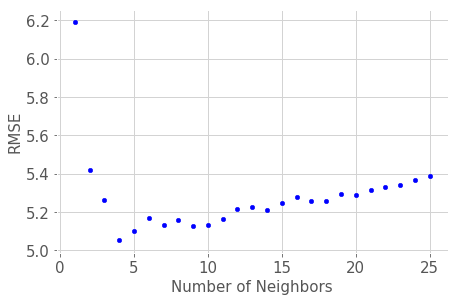

In [20]:
results

fig = plt.figure(figsize=(7,5))
ax = fig.gca()
plt.style.use('ggplot')
ax.grid(color='lightgray', linestyle='-', linewidth=1)
fig.suptitle('', fontsize = 20)

ax.scatter(results['k'], results['average RMSE'], color='blue', s=20)

ax.set_facecolor('white')
plt.xlabel('Number of Neighbors', fontsize=15)
plt.ylabel('RMSE', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.subplots_adjust(bottom = None, top = 0.8)
plt.show()


From the graph above we can see that RMSE drops sharply initially between 1-4 neighbors used in the algorithm. However, after this, RMSE begins to rise again. This makes sense because the more neighbors that are incorporated, the further from a true Median Housing Value the average may be because it's taking in more dissimilar samples as a comparison. From the graph we can estimate that the optimal number of neighbors to use for this data set is 4.

*Enter your observations here*

### Extra-Credit: Forward selection

Thus far the choice of predictor variables has been rather arbitrary. For extra credit, implement a basic [forward selection](http://www.stat.ubc.ca/~rollin/teach/643w04/lec/node41.html) algorithm to progressively include features that decrease the cross-validated RMSE of the model. Note that the optimal value of K may be different for each model, so you may want to use cross-validation to choose K each time (but it is also fine if you fix K at the optimal value from 2.7).  Create a graph that shows RMSE as a function of the number of features in the model. Label each point on the x-axis with the name of the feature that is added at that step in the forward selection algorithm. *(For instance, if the optimal single-feature model has CRIM with RMSE = 10, and the optimal two-feature model has CRIM+ZN with RMSE=9, the first x-axis label will say CRIM and the second x-axis lable with say ZN)*

In [14]:
bdata_train['MEDV'] = train_labels
tmp = np.asarray(bdata_test[['CRIM', 'RM']])[:, :2]
tmp2 = np.asarray(bdata_train[['CRIM', 'RM', 'MEDV']])[:, :5]
[distance(x1, tmp2, 2) for x1 in tmp[0]]
features = ['CRIM', 'RM']

test_MEDV=[]
for x1 in tmp:
    tmp3 = [[distance(x1, x[:len(features)], L), x[-1]] for x in tmp2]
    tmp3.sort()
    min_MED = tmp3[0][-1]
    test_MEDV.append(min_MED)

rmse = compute_rmse(test_MEDV, test_labels)
if type(rmse) is np.ndarray:
    rmse = rmse[0]
